In [1]:
import pandas as pd
import nltk
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx
warnings.filterwarnings("ignore")
%matplotlib inline  
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Task A

In [2]:
sent_scores = pd.read_csv('assignment 3 sentiment scores.csv')
sent_scores.head()

,ES,LS,RX,A8,A6,3series,5series,7series,XJ,Sclass
0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,5.0,2.0,1.0
1,NaN,NaN,3.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN
2,NaN,4.0,NaN,NaN,NaN,3.0,NaN,3.0,NaN,3.0
3,NaN,2.0,NaN,2.0,NaN,NaN,NaN,2.0,4.0,2.0
4,NaN,3.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,3.0


In [3]:
modelset=set(sent_scores.columns)

In [4]:
def compare(a,b):
    '''compare a and b to get the direction and weight
    if tie, then return noting'''
    maska=sent_scores[a].notnull()
    maskb=sent_scores[b].notnull()
    masked=sent_scores[maska&maskb]
    dif=round(sum(masked[a]-masked[b])/len(masked),2)
    
    if dif>0:
        return(b, a, dif)
    elif dif<0:
        return(a, b, -dif)

    else:
        return

In [5]:
from itertools import combinations
compare_result=[]
model_combine=list(combinations(modelset,2))
for i in model_combine:
    compare_result.append(compare(i[0],i[1]))
compare_result=[str for str in compare_result if str not in [None]]

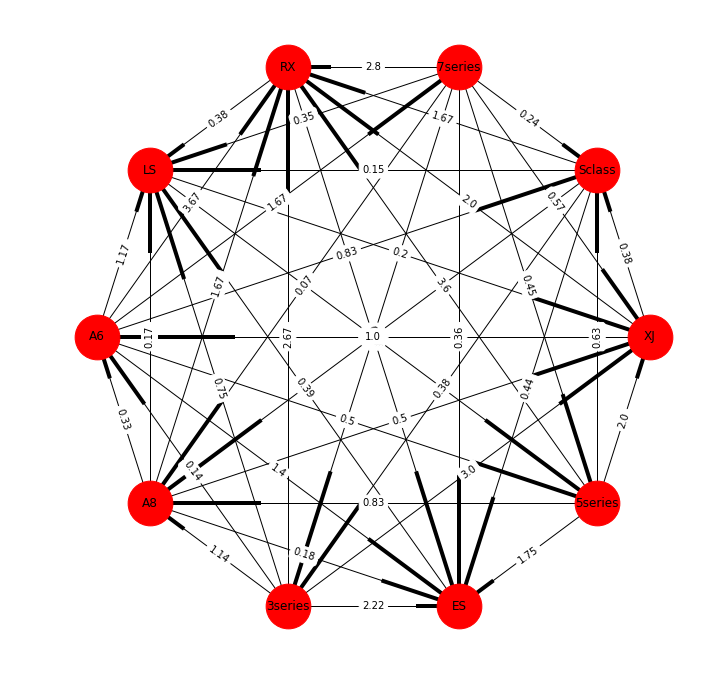

In [28]:
fig = plt.figure(figsize=(12, 12))
G = nx.DiGraph()
for i in compare_result:
    G.add_edge(i[0], i[1], weight=i[2])
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
pos = nx.shell_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)    
nx.draw(G, pos=pos, arrows=True, with_labels=True,node_size=2000)

plt.show()

Weighted graph:https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html

# Task B

In [15]:
models = ['A6','A8','3series','5series','7series','XJ','ES','LS','RX','Sclass']
sales = [20000,12000,220000,60000,14000,6600,135000,30000,120000,25000]
sales_df = pd.DataFrame({
    'Model':models,
    'Sales':sales
})
sales_df

,Model,Sales
0,A6,20000
1,A8,12000
2,3series,220000
3,5series,60000
4,7series,14000
5,XJ,6600
6,ES,135000
7,LS,30000
8,RX,120000
9,Sclass,25000


In [475]:
uw_relation_df=pd.DataFrame(columns=models, index=models)
uw_relation_df=uw_relation_df.fillna(0)
'''
Unweighted initialize
Just put 1 if there is a link, 0 otherwise
''' 
for i in compare_result:
    uw_relation_df.loc[i[0],i[1]]=1.0
'''
Change this dataframe into a numpy array 
since it is easy to calculate in python.
'''
uw_relation_array=np.array(uw_relation_df)

In [476]:
def calculateP(a):  
    '''
    Here we calculate the transmit probability matrix P
    '''
    c = zeros((a.shape),dtype = float)  
    for i in range(a.shape[0]):  
        for j in range(a.shape[1]):  
            c[i][j] = a[i][j] / (a[i].sum())   
    return transpose(c)  
  
def initializePr(a):   
    pr = zeros((a.shape[0],1),dtype = float)   
    for i in range(a.shape[0]):  
        pr[i] = 1.0  
    return pr  
      
def eeT_N(a): 
    eetn = zeros((a.shape[0],a.shape[1]),dtype = float)   
    for i in range(a.shape[0]):  
        eetn[i] = 1.0/(a.shape[0])
    return eetn
    
def get_A(re_array,damping_q):
    P = calculateP(re_array)    
    q = damping_q
    eetn=eeT_N(re_array)
    A=q*P+(1-q)*eetn
    return A    
    
def pageRank(A): 
    pr=initializePr(A)
    R=dot(A,pr)
    while(pr== R).all()==False:    
        pr = R
        R=dot(A,pr)
    return pr  


def get_Pagerank(re_array,damping_q):
    A=get_A(re_array,damping_q)
    return pageRank(A)

In [489]:
unweight_result=get_Pagerank(uw_relation_array,1)

unweight_result=[i[0]for i in unweight_result]
uw_result_df=pd.DataFrame({
    'Model':models,
    'UW_Pagerank':unweight_result
})
uw_result_df

,Model,UW_Pagerank
0,A6,0.649126
1,A8,0.482336
2,3series,0.193314
3,5series,1.284016
4,7series,0.108188
5,XJ,1.561318
6,ES,1.290707
7,LS,2.324610
8,RX,1.207431
9,Sclass,0.898954


In [478]:
w_relation_df=pd.DataFrame(columns=models, index=models)
w_relation_df=w_relation_df.fillna(0)
'''
Weighted initialize
Just put the weight if there is a link, 0 otherwise
''' 
for i in compare_result:
    w_relation_df.loc[i[0],i[1]]=i[2]
w_relation_array=np.array(w_relation_df)
weight_result=get_Pagerank(w_relation_array,1)
weight_result=[i[0]for i in weight_result]
w_result_df=pd.DataFrame({
    'Model':models,
    'W_Pagerank':weight_result
})
w_result_df

,Model,W_Pagerank
0,A6,0.511229
1,A8,0.152582
2,3series,0.045881
3,5series,1.291549
4,7series,0.092398
5,XJ,1.666051
6,ES,1.269037
7,LS,2.577013
8,RX,2.064184
9,Sclass,0.330077


In [497]:
merge1=pd.merge(left=uw_result_df,right=w_result_df,left_on='Model',right_on='Model')
result=pd.merge(left=merge1,right=sales_df,left_on='Model',right_on='Model')
result

,Model,UW_Pagerank,W_Pagerank,Sales
0,A6,0.649126,0.511229,20000
1,A8,0.482336,0.152582,12000
2,3series,0.193314,0.045881,220000
3,5series,1.284016,1.291549,60000
4,7series,0.108188,0.092398,14000
5,XJ,1.561318,1.666051,6600
6,ES,1.290707,1.269037,135000
7,LS,2.324610,2.577013,30000
8,RX,1.207431,2.064184,120000
9,Sclass,0.898954,0.330077,25000


In [499]:
np.corrcoef(result['UW_Pagerank'],result['Sales'])[0,1]

-0.18688453665421603

In [501]:

H = nx.Graph()
for u,v,d in G.edges(data=True):
    w = d['weight']
    if H.has_edge(u,v):
        H[u][v]['weight'] += w
    else:
        H.add_edge(u,v,weight=w)

In [518]:
from pandas import Series,DataFrame
un_ng = nx.pagerank(H)
un_ng=pd.DataFrame(Series(un_ng)).reset_index()

In [520]:
merge3=pd.merge(left=un_ng,right=result,left_on='index',right_on='Model')

In [521]:
merge3

,index,0,Model,UW_Pagerank,W_Pagerank,Sales
0,3series,0.117860,3series,0.193314,0.045881,220000
1,5series,0.111840,5series,1.284016,1.291549,60000
2,7series,0.078352,7series,0.108188,0.092398,14000
3,A6,0.121270,A6,0.649126,0.511229,20000
4,A8,0.063848,A8,0.482336,0.152582,12000
5,ES,0.083873,ES,1.290707,1.269037,135000
6,LS,0.051585,LS,2.324610,2.577013,30000
7,RX,0.200656,RX,1.207431,2.064184,120000
8,Sclass,0.062383,Sclass,0.898954,0.330077,25000
9,XJ,0.108333,XJ,1.561318,1.666051,6600


In [523]:
np.corrcoef(merge3[0],merge3['Sales'])[0,1]

0.42809040071415627

In [525]:
np.corrcoef(merge3['UW_Pagerank'],merge3['Sales'])[0,1]

-0.186884536654216